In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Define given values
fc = 28        #concrete compressive strenght, kg/cm2
fy = 420        #steel yield strenght, kg/cm2
b = 400        #column dimentions, cm
h = 400         #column dimentions, cm
dbar =29        #diameter of main reinforcement bar, cm
nbar = 6        #number of main reinforcement bar, cm
nbar_side = 3   #number of rebars at each side
cc = 40         #concrete cover in cm

#Tie diameter
if dbar <= 12:
    tie = 10
else:
    tie = 12


# Effective depth
deff = h - cc - tie - dbar/2

# Bar depht (d')
dprime = cc + tie +dbar/2

deff, dprime
(435.5, 64.5)

#Beta1 (stress block multiplier)
if fc <= 28:
    Beta1 = 0.85
else:
    Beta1 = max(0.85 - 0.05*(fc - 28)/7, 0.65)

Beta1

0.85

In [2]:
#Steel Areas
Ast = (np.pi * dbar**2 /4)*nbar_side    #Steel area at tension side
Asc= Ast                                #Steel area at compression side

Ast, Asc

(1981.5595662517621, 1981.5595662517621)

In [3]:
#Stresses and Strains
Es = 200000 #Steel modulus, MPa (constant)
ec = 0.003 #concrete maximum strain (constant)
ey = fy/Es  #Steel strain at yield point

def stress_strain(c):
    es = ec * (deff - c) / c    #Steel strain at tension side
    fs = es * Es    #tensile stress at tension side
    esprime = ec * (c - dprime) #Steel strain at compression side
    fsprime = esprime * Es  #tensile stress at compression side
    a = Beta1 * c   #compressive stress block depht
    return a, es, fs, esprime, fsprime

In [4]:
#Strenght reduction factor
def strenght_factor():
    phi_factor = 0.65 + 0.25 *(es - ey)/ (0.005 - ey)
    if phi_factor >= 0.9:
        phi, classify = 0.9, 'Tensile-controled'
    elif phi_factor <= 0.65:
        phi, classify = 0.65, 'Compression-controled'
    else:
        phi, classify = phi_factor, 'Transition'
    return phi, classify

In [5]:
# Forces and moments
def forces_moments():
    T = Ast * min(fy, fs)/1000    #tension force by steel at tension side
    Cc = 0.85 * fc * a * b/1000  #compression force by concrete
    Cs = Asc *(min(fy, fsprime) - (0.85*fc))/1000    #tension force by steel at compression side

    Pn = Cc + Cs - T     #Nominal axial Load capacity
    Pu = phi * Pn       #Ultimate axial Load capacity

    #Solve for eccentricity by taking moment about T:
    #Sum of Moments at T: Pn(ecc + h/2 - dprime) - Cc(deff - a/2) - Cs(deff - dprime) = 0
    ecc = (Cc*(deff - a/2) + Cs*(deff - dprime))/ Pn - (h/2 - dprime) 
    Mn = Pn * ecc /1000  #Nominal moment capacity
    Mu = phi * Mn        #Ultimate moment capacity
    return ecc, Pn, Pu, Mn, Mu


In [6]:
#Solve axial load and moment at varying 'c' values 

nom_load=[]
ult_load=[]
nom_moment=[]
ult_moment=[]
eccentricity=[]
phi_factor=[]

c_values = np.arange(600, 80, -5)
for c in c_values:
    a, es, fs, esprime, fsprime = stress_strain(c)
    phi, classify = strenght_factor()
    ecc, Pn, Pu, Mn, Mu = forces_moments()
    if ecc <= 1.5*h:
        nom_load.append(round(Pn))
        ult_load.append(round(Pu))
        nom_moment.append(round(Mn))
        ult_moment.append(round(Mu))
        eccentricity.append(round(ecc))
        phi_factor.append(round(phi, 2))

#Solve the above calculated data in a dataframe
dict = {'ecc(mm)': eccentricity, 'Pn(kN)': nom_load, 'Pu(kN)': ult_load, 'Mn(kN.m)': nom_moment, \
    'Mu(kN.m)': ult_moment, 'phi': phi_factor}

df = pd.DataFrame(dict)

#Print the last 10 rows of the dataframe to verify
df.tail(104)

,ecc(mm),Pn(kN),Pu(kN),Mn(kN.m),Mu(kN.m),phi
0,-38,6168,4009,-233,-151,0.65
1,-36,6122,3980,-220,-143,0.65
2,-34,6076,3950,-206,-134,0.65
3,-32,6030,3920,-194,-126,0.65
4,-30,5984,3889,-181,-118,0.65
...,...,...,...,...,...,...
99,434,802,722,348,313,0.90
100,451,762,686,343,309,0.90
101,469,722,649,339,305,0.90
102,490,681,613,334,300,0.90


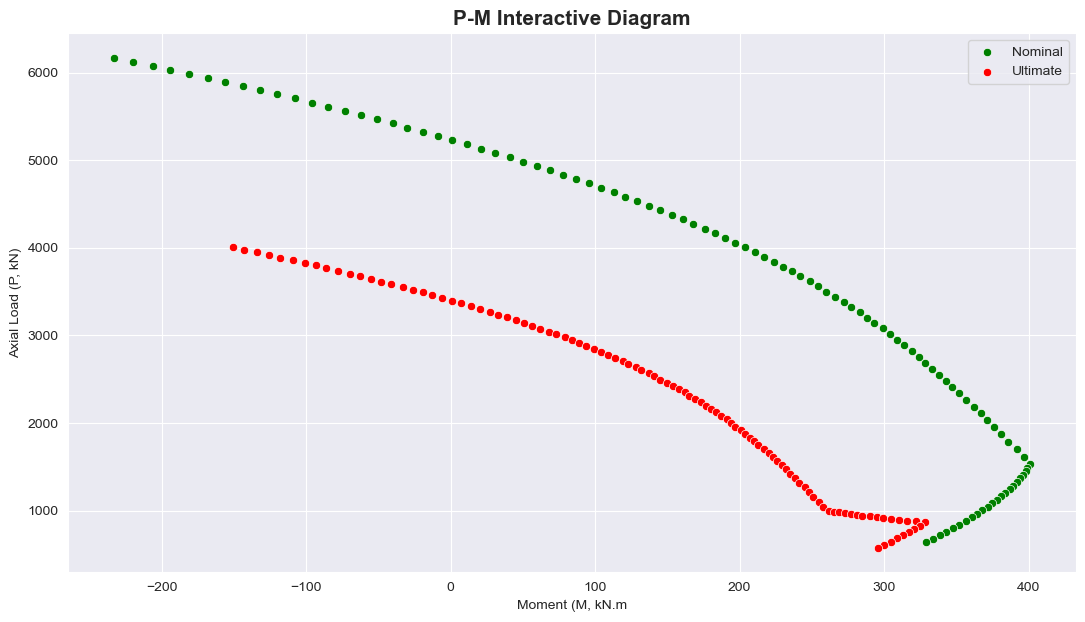

In [7]:
#Plotting the P.M Interaction Diagram

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(13,7))
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=15)
ax = sns.scatterplot(x='Mn(kN.m)', y='Pn(kN)', data=df, color='g', label='Nominal')
sns.scatterplot(x='Mu(kN.m)', y='Pu(kN)', data=df, color='r', label='Ultimate')
ax.set_xlabel('Moment (M, kN.m')
ax.set_ylabel('Axial Load (P, kN)')
plt.title('P-M Interactive Diagram')
plt.show()
